# **Data Mining for Confidence Level Detection**

Lydia Lonzarich and Katie Park

CPSC 322-01, Fall 2025

# Import Libraries

In [3]:
import importlib

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyRandomForestClassifier, MyDecisionTreeClassifier, MyNaiveBayesClassifier

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable

import matplotlib.pyplot as plt

import numpy as np

# **Introduction**

## Dataset Description

The dataset used for this project is called "Confidence Detection Dataset," from Kaggle: https://www.kaggle.com/datasets/muhammadkhubaibahmad/confidence-detection-dataset

</br>

The dataset contains features extracted from human body landmarks and postures to classify confidence levels, which is also what is being classified for this project.


## Findings

3 different classifiers were used on the dataset:
1. Random Forest Classifier
1. Decision Tree Classifier
1. Naive Bayes Classifier

After using all 3 classifiers on the dataset, the classifier that performed the best was the Naive Bayes Classifier.

# **Data Analysis**

## Dataset Information

The dataset includes 19 attributes and 1 target (as defined by the dataset author), with 5,949 rows in total, 1 of which is the header.

The class that is predicted from the attributes is "confidence_label," which can contains the class labels:
1. confident
2. neutral
3. low

</br>

Although there are 19 attributes used to classify confidence_label, only 9 attributes were used in the different classifier approaches. The 9 attributes were chosen as they were the only attributes that could be changed based on confidence level. Certain attributes in the dataset, such as "eye_distance," for example, which represents the distance between eyes, do not change if a person is confident or not, and so only attributes that were deemed to be possible predictors for confidence_label were used. These attributes include:
1. "body_lean_x"
    * A float value representing the horizontal body lean ratio
1. "shoulder_center_x"
    * A float value representing the X-coordinate of the shoulder center
1. "hip_center_x"
    * A float value representing the X-coordinate of the hip-center
1. "spine_angle"
    * A float value representing the spine inclination angle in degrees
1. "head_tilt_angle"
    * A float value representing the head tilt angle in degrees
1. "shoulder_slope"
    * A float value representing the slope of the shoulder line
1. "head_direction"
    * A categorical value representing the head orientation (can be "Looking Straight," "Center," "Looking Right," or "Looking Left")
1. "arm_position"
    * A categorical value representing the arm position (can be "Partially Open," "Closed Arms," or "Open Arms")
1. "posture"
    * A categorical vaue representing the general body posture (can be "Upright," "Stiff," or "Slouched).


## Dataset Loading

Below, the dataset is extracted and saved as a MyPyTable object. A copy is then created, as all the float values will undergo normalization and discretization for algorithm compatibility for all classifiers. The copy will ensure the original dataset's values are not changed, retaining its true values.


The copy of the dataset then undergoes normalization, ensuring all values are between [0, 1]. After being normalized, the values then undergo discretization, wherein every 0.1 (normalized) value is set to a value between [1, 10]. This ensures algorithms such as Decision Trees have a limited number of attribute values, preventing every unique float value creating a branch in the tree.

In [4]:
confidence_raw_data = MyPyTable().load_from_file("input_files/confidence_features.csv") # dataset before processing
confidence = confidence_raw_data.new_deep_copy() # the dataset we will normalize. Original dataset retains its true values

all_attributes = ["body_lean_x", "shoulder_center_x", "hip_center_x", "spine_angle", "head_tilt_angle", "shoulder_slope", "head_direction", "arm_position", "posture"]
continuous_attributes = all_attributes[:6]
categorical_attributes = all_attributes[6:]

# normalize cols that have type=float attribute values.
confidence.normalize_columns(continuous_attributes)

## Exploratory Data Analysis

In this subsection exploratory data analysis (EDA) is performed on our **raw dataset**, which involves examining class imbalances, identifying outliers or missing values, and computing summary statistics (e.g., min, max, mean, median),

### Examine class imbalances
In Figure 1 below, the distribution of class labels in the dataset are visualized, with over half being classified as "Confident," and the class with the smallest percentage being "Low," making up only 19.4%.

<function matplotlib.pyplot.show(close=None, block=None)>

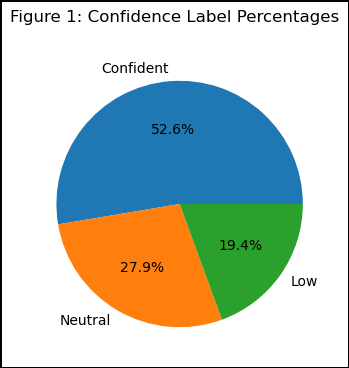

In [5]:
# Pie chart of the percentages of each confidence label in the dataset

# reset figure
plt.figure(figsize = (4, 4))

# get x and y values (frequency of each confidence label)
freq = myutils.get_frequency(confidence_raw_data.get_column("confidence_label"))

xs = []
ys = []

for key in freq:
    xs.append(key)
    ys.append(freq[key])

# create the chart (with number of decimals)
plt.pie(ys, labels = xs, autopct = "%1.1f%%")

# add border to current figure
fig = plt.gcf()

# add title to pie chart, and change formatting
fig.suptitle("Figure 1: Confidence Label Percentages")
fig.patch.set_edgecolor("black")
fig.patch.set_linewidth(1)

plt.show

### Identify Outliers and Missing Values
There are no missing values or outliers in this dataset. Note, that we are only looking at the continuous numerical features that will be used to train and evaluate the following classifiers because we can not compute the following for categorical attribute values.

In [6]:
# the 'columns' list stores each column as a list of its values.
data = confidence_raw_data.data
columns = list(zip(*data)) # transpose the data here.

# initialize a dictionary to store outliers in each column.
outliers = {att: [] for att in continuous_attributes}

# iterate over all values in each column.
for att, col in zip(continuous_attributes, columns):
    col = np.array(col, dtype=float) # convert the column to an array.

    mean = np.mean(col)
    std = np.std(col)

    for val in col:
        z_score = (val - mean) / std
        if z_score > 3 or z_score < -3: # rule to determine outliers with z-score.
            outliers[att].append(val)

### Compute Summary statistics

Listed below are the minimum, maximum, middle, average, and median values of each of the continuous numerical features that will be used to train and evaluate the following classifiers.

In [7]:
# generate a summary statistics table.
summary_table = confidence_raw_data.compute_summary_statistics(continuous_attributes)

# print the summary table.
summary_table.pretty_print()

attribute                     min          max    mid         avg        median
-----------------  --------------  -----------  -----  ----------  ------------
body_lean_x          -0.0877575      0.0760831  -0.01  -0.0032298   -0.00383452
shoulder_center_x     0.339849       0.671296    0.51   0.518224     0.517633
hip_center_x          0.369373       0.65067     0.51   0.521454     0.521118
spine_angle          84.8792        93.8617     89.37  89.7742      89.7659
head_tilt_angle    -179.901        179.967       0.03  -1.56391    -10.0826
shoulder_slope        1.66893e-06    0.157152    0.08   0.0309243    0.0237475


## Visualizing "Life Cycle" of our Data Preprocessing

This subsection describes and visualizes how we performed data preprocessing to prepare our features for classification tasks.

</br>

Figure 2 below shows a histogram, representing the distribution of the raw, unchanged attribute values for the 'body_lean_x" attribute in the original dataset.

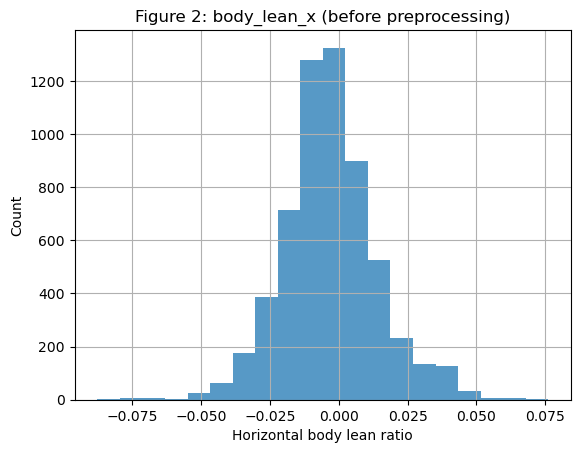

In [8]:
# Histogram of the body_lean_x attribute before preprocessing

# reset figure
plt.figure()

# get x values
x = confidence_raw_data.get_column("body_lean_x")

plt.hist(x, bins = 20, alpha = 0.75)
plt.grid(True)

# add titles
plt.title("Figure 2: body_lean_x (before preprocessing)")
plt.xlabel("Horizontal body lean ratio")
plt.ylabel("Count")

plt.show()

Figure 3 below shows the results of data normalization. The histogram represents the distribution of the 'body_lean_x' attribute  after being normalized to the range [0, 1].

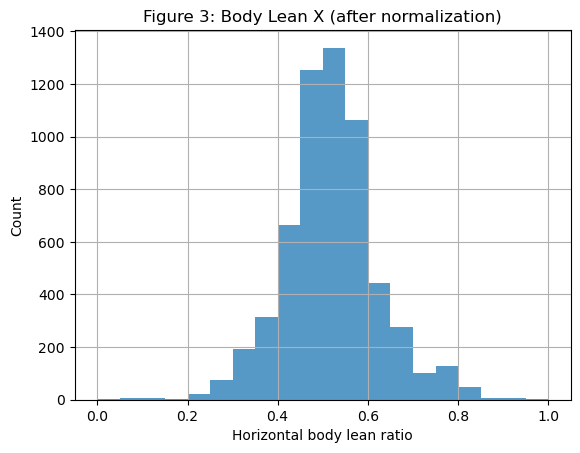

In [9]:
# Histogram of the body_lean_x attribute AFTER normalization

# reset figure
plt.figure()

# get x values after normalization
x = confidence.get_column("body_lean_x")

plt.hist(x, bins = 20, alpha = 0.75)
plt.grid(True)

# add titles
plt.title("Figure 3: Body Lean X (after normalization)")
plt.xlabel("Horizontal body lean ratio")
plt.ylabel("Count")

plt.show()

After being normalized, the values are then discretization, where every 0.1 value is set to a value between [1, 10], meaning values between [0, 0.1] are set to 1, values between (0.1, 0.2] are set to 2, etc.

In [10]:
# find the column indices of the attributes we're using
att_indices = []
for att in all_attributes:
   att_idx = confidence.column_names.index(att)
   att_indices.append(att_idx)

# discretize values (to make continuous attribute vals --> categorical attribute vals)
for row_index, row in enumerate(confidence.data):
    for val_index, value in enumerate(row):
        if val_index in att_indices and type(confidence.data[row_index][val_index]) != str:
            confidence.data[row_index][val_index] = myutils.my_discretizer(confidence.data[row_index][val_index])

Figure 4 below shows the distribution of the normalized and discretized values for the 'body_lean_x' attribute.

This normalization and discretization is performed to all float values that are attributes, ensuring consistency across all numeric values for future classification.

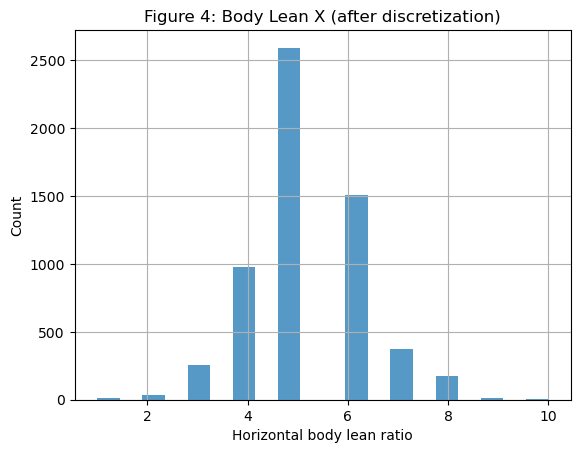

In [11]:
# Histogram of the body_lean_x attribute after discretization

# reset figure
plt.figure()

# get x values after normalization AND discretization
x = confidence.get_column("body_lean_x")

plt.hist(x, bins = 20, alpha = 0.75)
plt.grid(True)

# add titles
plt.title("Figure 4: Body Lean X (after discretization)")
plt.xlabel("Horizontal body lean ratio")
plt.ylabel("Count")

plt.show()

As mentioned previously, only 9 out of the 19 possible columns were chosen to be possible predictors for the target label. In figures 5 and 6 below, the bar graphs indicate the difference in relationship between the target label (confidence label), and the column.

Figure 5 represents a column that was not chosen to be a predictor for the target label, as the column represents an unchangeable human feature (more specifically, the horizontal offset between the nose and the eye). Unchangeable human features are unlikely to influence the confidence label, as they do not change if a person is confident or not.

On the other hand, Figure 6 represents a column that was chosen to be a predictor for the target label, as the column represents a changeable human feature (more specifically, how raised a person's shoulder is). 

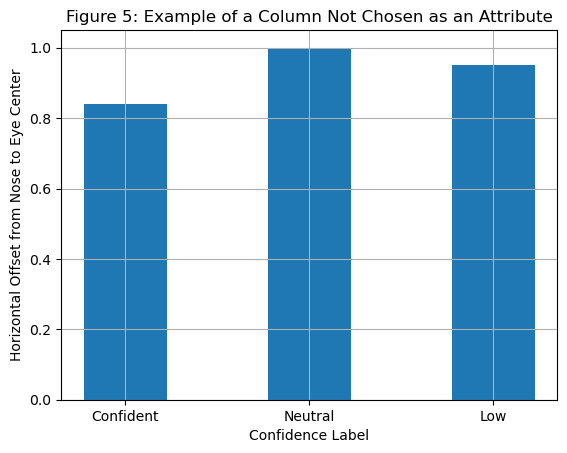

In [12]:
plt.figure()

confidence.normalize_columns(["nose_eye_center_offset_x"])

x = confidence.get_column("confidence_label")
y = confidence.get_column("nose_eye_center_offset_x")

plt.bar(x, y, 0.45, align = "center")

plt.grid(True)
plt.xlabel("Confidence Label")
plt.ylabel("Horizontal Offset from Nose to Eye Center")
plt.title("Figure 5: Example of a Column Not Chosen as an Attribute")
plt.show()


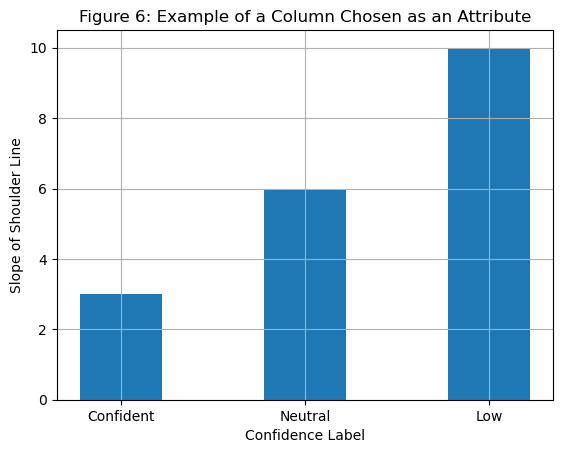

In [13]:
plt.figure()

x = confidence.get_column("confidence_label")
y = confidence.get_column("shoulder_slope")

plt.bar(x, y, 0.45, align = "center")

plt.grid(True)
plt.xlabel("Confidence Label")
plt.ylabel("Slope of Shoulder Line")
plt.title("Figure 6: Example of a Column Chosen as an Attribute")
plt.show()

# **Classification Results**

The 3 different classification approaches that were developed were: Decision Tree classifier, Random Forest classifier, and Naive Bayes classifier. Decision Tree and Naive Bayes classifiers used the k-fold cross validation approach to create training and testing sets, while the Random Forest classifier used the random stratified test set.

</br>

**K-Fold Cross Validation**

K-fold cross validation is used to give a robust estimate of the predictive performance of each model and interpret model stability by training and evaluating the model on different folds, or subsets, of the same dataset. During cross validation, the entire dataset is partitioned into k (approximately) equal folds, or subsets. Training is completed k times, wherein each fold becomes the test set exactly once.

The Decision Tree and Naive Bayes classifiers created 10 folds (k = 10) for the dataset.

</br>
 
**Random Stratified Test Set**

Random stratified test set generates testing sets consisting of a portion of the original dataset (in this case, 1/3). The testing set is compiled to maintain the class distribution of the original dataset, which is especially important as the original dataset is unbalanced, with more than half of all instances being labeled "confidence." Any remaining instances (in this case, 2/3) make up the training set.

# Implementing Decision Tree for Classification

Below, the estimated predictive accuracy of the Decision Tree classifier is found using K-fold cross validation. Then, the Decision Tree classifier is trained and used to classify unseen instances. Various performance metrics are used to verify the performance of the classifier.


</br>


**Fitting the Decision Tree Classifier**

After k sets of training and testing sets are created, a decision tree is fitted for each training set. Each decision tree is created by using the Top Down Induction of Decision Trees Algorithm. This algorithm selects an attribute to split the data based on having the lowest entropy (meaning the least uncertainty). Each partition is then repeatedly partitioned until either all class values for a partion is the same, there are no more attributes to split on, or there are no more instances to partition. In all cases, a leaf node is created.


</br>


**Predicting Unseen Instances**

After a decision tree is created for a fold, the testing set is then used against the tree to predict each instance's class label. This is done by traversing down the tree, based on the attribute value at each node.

</br>


Below is the k-fold cross validation process.

In [14]:
# define X and y data
X = confidence.get_column_rows(all_attributes)
y = confidence.get_column("confidence_label")

# get all unique class labels.
labels = list(set(y))

# compute k fold cross validation with k=10 folds to evaluate model performance across different train and test subsets of data.
acc, err_rate, precision, recall, f1, y_trues, y_preds = myutils.cross_val_predict(X, y, 10, MyDecisionTreeClassifier, True)

**Decision Tree Performance Metrics for k-Fold Cross Validation**

For each fold in the dataset, after the Decision Tree classifier is fitted and evaluated against the test set, the performance metrics for each fold are found. After all k folds are fitted and evaluated against the test set, the average for each performance metric are found. The performance metrics include:
- Accuracy
- Error rate
- Precision
- Recall
- F1 Score

The results of each performance metrics are output below

In [15]:
print("K-FOLD CROSS VALIDATION (k=10) PERFORMANCE METRICS FOR DECISION TREE")
print(f"(Average) Accuracy Score: {round(acc, 2)}")
print(f"(Average) Error Rate: {round(err_rate, 2)}")
print(f"(Average) Precision Score: {round(precision, 2)}")
print(f"(Average) Recall Score: {round(recall, 2)}")
print(f"(Average) F1 Score: {round(f1, 2)}")

K-FOLD CROSS VALIDATION (k=10) PERFORMANCE METRICS FOR DECISION TREE
(Average) Accuracy Score: 0.73
(Average) Error Rate: 0.27
(Average) Precision Score: 0.78
(Average) Recall Score: 0.73
(Average) F1 Score: 0.69


Below, is the confusion matrix for the Decision Tree classifier.

In [16]:
labels = sorted(list(set(y))) # get all unique labels
matrix_header = ["Confidence Label"] + labels + ["Total", "Recognition (%)"] # create matrix header

cm = myevaluation.confusion_matrix(y_trues, y_preds, labels)
conf_matrix_copy = myutils.list_deep_copy(cm)

for index, row in enumerate(conf_matrix_copy):
    row.append(sum(row)) # sum of each row

    # find recognition percentage of each class
    try:
        row.append(round(((row[index] / row[-1]) * 100), 2))
    except ZeroDivisionError:
        row.append(0) # if total sum is 0
    row.insert(0, labels[index]) # inserts class labels as column

matrix = MyPyTable(matrix_header, conf_matrix_copy)

print("CONFUSION MATRIX FOR DECISION TREE CLASSIFIER\n")

matrix.pretty_print()

CONFUSION MATRIX FOR DECISION TREE CLASSIFIER

Confidence Label      Confident    Low    Neutral    Total    Recognition (%)
------------------  -----------  -----  ---------  -------  -----------------
Confident                  3090      0         42     3132              98.66
Low                         277    870          8     1155              75.32
Neutral                    1110    159        393     1662              23.65


**Compute Per-Class Accuracy**

Per-class accuracy reveals how well the Decision Tree classifier performs on each individual class instead of the just the overall accuracy. 

We find that the 'Confident' class accuracy is around 99%, which aligns with our expectations, as the 'Confident' class is the majority class in this dataset and decision trees often have an easier time predicting the majority class correctly. This confirms that accuracy may not be the most meaningful measure of model performance when computed without distinguishing between classes.

In [17]:
# create a dictionary to store the accuracy per class label
class_accuracies = dict()

unique_labels = list(set(y)) # find the unique labels in the class.

for idx in range(len(unique_labels)): 
    tp = cm[idx][idx] # grab the entry in the diagonal of the current row. This is the number of TP
    total_trues = sum(cm[idx]) # grab the total number of true values for the current class label.
    acc = tp / total_trues # compute the class acc.
    acc = round(acc, 2) # round the acc to 2 decimal places.
    class_accuracies[labels[idx]] = acc # store this class acc as the value for the appropriate key in the dictionary. 


# display accuracies per class
print("Per-Class Accuracies: ", class_accuracies)

Per-Class Accuracies:  {'Confident': 0.99, 'Low': 0.75, 'Neutral': 0.24}


**Print Decision Rules for Decision Tree**

In [18]:
# create a new decision tree classifier and train it on all data.
tree = MyDecisionTreeClassifier()
tree.fit(X, y)

# print decision rules.
tree.print_decision_rules(attribute_names=all_attributes, class_name="confidence_label")

IF att7 == Closed Arms THEN confidence_label = Low
IF att7 == Open Arms THEN confidence_label = Confident
IF att7 == Partially Open AND att5 == 1 THEN confidence_label = Confident
IF att7 == Partially Open AND att5 == 2 AND att6 == Center THEN confidence_label = Confident
IF att7 == Partially Open AND att5 == 2 AND att6 == Looking Left THEN confidence_label = Confident
IF att7 == Partially Open AND att5 == 2 AND att6 == Looking Right THEN confidence_label = Confident
IF att7 == Partially Open AND att5 == 2 AND att6 == Looking Straight THEN confidence_label = Confident
IF att7 == Partially Open AND att5 == 3 THEN confidence_label = Confident
IF att7 == Partially Open AND att5 == 4 THEN confidence_label = Neutral
IF att7 == Partially Open AND att5 == 5 THEN confidence_label = Neutral
IF att7 == Partially Open AND att5 == 6 THEN confidence_label = Neutral
IF att7 == Partially Open AND att5 == 7 THEN confidence_label = Low
IF att7 == Partially Open AND att5 == 8 THEN confidence_label = Low

**Decision Tree Visualization**

The tree is also visualized under the name "DT-Visual" in the "output_files" folder.

In [19]:
tree.visualize_tree("DT_dot", "output_files/DT-Visual", all_attributes)

# Implementing Random Forest for Classification

Below, the Random Forest classifier is fitted, and then used to classify unseen instances. After, various performance metrics are used to verify the performance of the Random Forest classifier.

</br>

**Generating Test and Training Sets**

For the Random Forest classifier, a pre-processing step occurs to the given dataset, wherein both training and testing sets are generated internally. This is done by first generating a random stratified test set, consisting of one third of the original dataset, with the test set having the same class distribution as the original dataset. After the test set is created, any remaining rows in the dataset that were not selected make up the training set which is then used to fit the classifier.

</br>

**Fitting the Classifier**

Fitting the classifier is done by creating N "random" decision trees using bootstrapping over the remainder set. Bootstrapping is a technique where the training set is created by randomly selecting rows with replacement, and the test set is made up of any values not in the training set. During the Top Down Induction for Decision Trees Algorithm for generating each tree in the forest, F randomly chosen attributes are selected as candidate attributes to partition the data on at each node. Note that entropy is still used to determine the best attribute to partition on, similar to the Decision Tree classifier. After all N trees have been created, the M most accurate decision trees of the N trees are selected to be used for the random forest classifier. Note: the accuracy was based on the training and testing sets found using boostrapping.

For this dataset, after testing against multiple N, F, and M values, it was determined the best parameters were:
1. N = 50
1. M = 15
1. F = 5

Note: the random forest classifier requires the decision tree classifier, as N trees are created from the dataset.

In [20]:
# define X and y data
X = confidence.get_column_rows(all_attributes)
y = confidence.get_column("confidence_label")

# create a random forest classifer instance using the best N, M, and F parameters found.
myForest = MyRandomForestClassifier(N=50, M=15, F=5)

# create the training and testing sets
X_train, X_test, y_train, y_test = myForest.generate_test_set(X, y)

# train the random forest classifier on our train data. (class does internal split into train and test set, so here we just use internal train set).
myForest.fit(X_train, y_train)

**Predicting Unseen Instances**

After the Random Forest classifier is fitted, the testing sets found earlier are then used to against the classifier. This is done by running each unseen instance against all M trees in the forest. The class label predicted the most out of the M trees is then considered the predicted class for that unseen attribute.

In [21]:
y_pred = myForest.predict(X_test)

**Random Forest Performance**

After the class predictions are found against the unseen instances, various metrics are used against the classifier to verify its performance. The performance metrics include:
- Accuracy
- Error rate
- Precision
- Recall
- F1 Score


The results of each performance metric is ouputted below.

In [22]:
print("RANDOM STRATIFIED TEST SET PERFORMANCE METRICS FOR RANDOM FOREST")
print(f"Accuracy Score: {round(myevaluation.accuracy_score(y_test, y_pred), 2)}")
print(f"Error Rate: {round(1 - myevaluation.accuracy_score(y_test, y_pred), 2)}")
print(f"Precision Score: {round(myevaluation.multiclass_precision_score(y_test, y_pred, ["Confident", "Neutral", "Low"]), 2)}")
print(f"Recall Score: {round(myevaluation.multiclass_recall_score(y_test, y_pred, ["Confident", "Neutral", "Low"]), 2)}")
print(f"F1 Score: {round(myevaluation.multiclass_f1_score(y_test, y_pred, ["Confident", "Neutral", "Low"]), 2)}")

RANDOM STRATIFIED TEST SET PERFORMANCE METRICS FOR RANDOM FOREST
Accuracy Score: 0.72
Error Rate: 0.28
Precision Score: 0.8
Recall Score: 0.72
F1 Score: 0.68


Below, is the confusion matrix for the Decision Tree classifier.

In [23]:
labels = sorted(list(set(y))) # get all unique labels
matrix_header = ["Confidence Label"] + labels + ["Total", "Recognition (%)"] # create matrix header

cm = myevaluation.confusion_matrix(y_trues, y_preds, labels)
conf_matrix_copy = myutils.list_deep_copy(cm)

for index, row in enumerate(conf_matrix_copy):
    row.append(sum(row)) # sum of each row

    # find recognition percentage of each class
    try:
        row.append(round(((row[index] / row[-1]) * 100), 2))
    except ZeroDivisionError:
        row.append(0) # if total sum is 0
    row.insert(0, labels[index]) # inserts class labels as column

matrix = MyPyTable(matrix_header, conf_matrix_copy)

print("CONFUSION MATRIX FOR RANDOM FOREST CLASSIFIER\n")
matrix.pretty_print()

CONFUSION MATRIX FOR RANDOM FOREST CLASSIFIER

Confidence Label      Confident    Low    Neutral    Total    Recognition (%)
------------------  -----------  -----  ---------  -------  -----------------
Confident                  3090      0         42     3132              98.66
Low                         277    870          8     1155              75.32
Neutral                    1110    159        393     1662              23.65


**Compute Per-Class Accuracy**

Per-class accuracy reveals how well the Random Forest classifier performs on each individual class instead of the just the overall accuracy. 

We find that the 'Confident' class accuracy is around 99%, which aligns with our expectations, as the 'Confident' class is the majority class in this dataset and decision trees often have an easier time predicting the majority class correctly. This confirms that accuracy may not be the most meaningful measure of model performance when computed without distinguishing between classes.

In [24]:
# create a dictionary to store the accuracy per class label
class_accuracies = dict()

unique_labels = list(set(y)) # find the unique labels in the class.

for idx in range(len(unique_labels)): 
    tp = cm[idx][idx] # grab the entry in the diagonal of the current row. This is the number of TP
    total_trues = sum(cm[idx]) # grab the total number of true values for the current class label.
    acc = tp / total_trues # compute the class acc.
    acc = round(acc, 2) # round the acc to 2 decimal places.
    class_accuracies[labels[idx]] = acc # store this class acc as the value for the appropriate key in the dictionary. 


# display accuracies per class.
print("Per-Class Accuracies: ", class_accuracies)

Per-Class Accuracies:  {'Confident': 0.99, 'Low': 0.75, 'Neutral': 0.24}


**Print Decision Rules for a Decision Tree in Random Forest**

In [25]:
# "grab" a tree from the trees that make up the random forest.
tree = myForest.trees[0]

# print decision rules.
tree.print_decision_rules(attribute_names=all_attributes, class_name="confidence_label")

IF att5 == 1 AND att7 == Closed Arms THEN confidence_label = Low
IF att5 == 1 AND att7 == Open Arms THEN confidence_label = Confident
IF att5 == 1 AND att7 == Partially Open THEN confidence_label = Confident
IF att5 == 2 AND att7 == Closed Arms THEN confidence_label = Low
IF att5 == 2 AND att7 == Open Arms AND att6 == Center THEN confidence_label = Low
IF att5 == 2 AND att7 == Open Arms AND att6 == Looking Left THEN confidence_label = Neutral
IF att5 == 2 AND att7 == Open Arms AND att6 == Looking Right THEN confidence_label = Confident
IF att5 == 2 AND att7 == Open Arms AND att6 == Looking Straight THEN confidence_label = Confident
IF att5 == 2 AND att7 == Partially Open THEN confidence_label = Confident
IF att5 == 3 AND att7 == Closed Arms THEN confidence_label = Neutral
IF att5 == 3 AND att7 == Open Arms THEN confidence_label = Confident
IF att5 == 3 AND att7 == Partially Open THEN confidence_label = Confident
IF att5 == 4 AND att7 == Closed Arms THEN confidence_label = Low
IF att5 =

**Random Forest Visualization**

The tree is also visualized under the name "RF-Visual" in the "output_files" folder.

In [26]:
tree.visualize_tree("DT_dot", "output_files/RF-Visual", all_attributes)

**Best Attribute that Indicated Class Label**

The overall best attribute that was the most predictive of confidence label was the arm_position. This is because the decision tree would always split on the arm_position attribute first, meaning it had the lowest entropy/highest information gain. And for the random forest, whenever the arm_position attribute was randomly chosen to be in the subset of all the attributes, the arm_position was consistently chosen to be the attribute to partition data on. This means the arm_position attribute was the best attribute to indicate the confidence label.

# Implementing Naive Bayes for Classification

Below, the estimated predictive accuracy of the Naive Bayes classifier is found using K-fold cross validation. Then, the Naive Bayes classifier is trained and used to classify unseen instances. Various performance metrics are used to verify the performance of the classifier.


</br>


**Fitting the Naive Bayes Classifier**

Fitting in Naive Bayes involves using the training data to estimate all probabilities the model needs to generate predictions.

For each fold during training, the class priors and class conditional probabilities are computed.

- Class priors are the probability of each class label ocurring in the training data. These are computed by dividing the total number of instances of each label by the total number of training instances.
- Class conditional probabilities are the probability of each feature occurring given a specific class label. For each given class, the conditional probabilities are found by dividing the total number of instances with each feature by the total number of instances with that class.

Together, the class priors and conditional probabilities serve as the "learned" parameters of the Naive Bayes classifier.


</br>


**Predicting Unseen Instances**

After a Naive Bayes classifier is fitted, the testing set is then used to predict each instance's class label. This is done by computing its posterior probability for each unique class label in the dataset, which is the probability of that label occuring given the attribute values in that test instance. The posterior probability for each class is calculated by multiplying the class prior by a sum of each conditional probability for the class. Once the posterior probabilities are found for each class given the test instance, the class assigned to the test instance is the largest posterior probability found.


</br>


Below is the k-fold cross validation process.

In [27]:
# define X and y data
X = [[row[idx] for idx in att_indices] for row in confidence.data]
y = confidence.get_column("confidence_label")

# get all unique class labels.
labels = list(set(y))

# compute the avg acc and error rate, avg precision, avg recall, and avg F1 over each train/test split of the data.
acc, err_rate, precision, recall, f1, y_trues, y_preds = myutils.cross_val_predict(X, y, 10, MyNaiveBayesClassifier, True)

**Naive Bayes Performance Metrics for k-Fold Cross Validation**

For each fold in the dataset, after the Naive Bayes Classifier is fitted and evaluated against the test set, the performance metrics for each fold are found. After all k folds are fitted and evaluated against the test set, the average for each performance metric is found.

The performance metrics include:
1. Accuracy
1. Error rate
1. Precision
1. Recall
1. F1 Score

The results of each performance metric is output below

In [28]:
print("K-FOLD CROSS VALIDATION (k=10) PERFORMANCE METRICS FOR NAIVE BAYES")
print(f"(Average) Accuracy Score: {round(acc, 2)}")
print(f"(Average) Error Rate: {round(err_rate, 2)}")
print(f"(Average) Precision Score: {round(precision, 2)}")
print(f"(Average) Recall Score: {round(recall, 2)}")
print(f"(Average) F1 Score: {round(f1, 2)}")

K-FOLD CROSS VALIDATION (k=10) PERFORMANCE METRICS FOR NAIVE BAYES
(Average) Accuracy Score: 0.74
(Average) Error Rate: 0.26
(Average) Precision Score: 0.74
(Average) Recall Score: 0.74
(Average) F1 Score: 0.73


Below, is the confusion matrix for the Naive Bayes classifier.

In [29]:
labels = sorted(list(set(y))) # get all unique labels
matrix_header = ["Confidence Label"] + labels + ["Total", "Recognition (%)"] # create matrix header

cm = myevaluation.confusion_matrix(y_trues, y_preds, labels)
conf_matrix_copy = myutils.list_deep_copy(cm)

for index, row in enumerate(conf_matrix_copy):
    row.append(sum(row)) # sum of each row

    # find recognition percentage of each class
    try:
        row.append(round(((row[index] / row[-1]) * 100), 2))
    except ZeroDivisionError:
        row.append(0) # if total sum is 0
    row.insert(0, labels[index]) # inserts class labels as column

matrix = MyPyTable(matrix_header, conf_matrix_copy)

print("CONFUSION MATRIX FOR NAIVE BAYES CLASSIFIER\n")
matrix.pretty_print()

CONFUSION MATRIX FOR NAIVE BAYES CLASSIFIER

Confidence Label      Confident    Low    Neutral    Total    Recognition (%)
------------------  -----------  -----  ---------  -------  -----------------
Confident                  2799     23        310     3132              89.37
Low                         222    805        128     1155              69.7
Neutral                     705    138        819     1662              49.28


**Compute Per-Class Accuracy**

Per-class accuracy reveals how well the Naive Bayes classifier performs on each individual class instead of the just the overall accuracy. 

We find that the 'Confident' class accuracy is around 99%, which aligns with our expectations, as the 'Confident' class is the majority class in this dataset and decision trees often have an easier time predicting the majority class correctly. This confirms that accuracy may not be the most meaningful measure of model performance when computed without distinguishing between classes.

In [30]:
# create a dictionary to store the accuracy per class label
class_accuracies = dict()

unique_labels = list(set(y)) # find the unique labels in the class.

for idx in range(len(unique_labels)): 
    tp = cm[idx][idx] # grab the entry in the diagonal of the current row. This is the number of TP
    total_trues = sum(cm[idx]) # grab the total number of true values for the current class label.
    acc = tp / total_trues # compute the class acc.
    acc = round(acc, 2) # round the acc to 2 decimal places.
    class_accuracies[labels[idx]] = acc # store this class acc as the value for the appropriate key in the dictionary. 


# display accuracies per class.
print("Per-Class Accuracies: ", class_accuracies)

Per-Class Accuracies:  {'Confident': 0.89, 'Low': 0.7, 'Neutral': 0.49}


## Results

Overall, all the classifiers had similar performance ratings across all metrics. As shown above, each classifier had accuracy, precision, and recall scores around 75%, however the Random Forest classifier was usually inconsistent in its accuracy, ranging between a 65% - 80%. Overall, however, all classifiers performed similarly.

This means there is not a single classifier that would be considered the "best" one for the confidence dataset. 

After Testing per-class accuracy, we found that the model always performed best on the 'confident' class, which makes sense because this class makes up over 50% of the instances in the dataseta and it is much easier to label a class as XYZ given a dataset with the majority of its class instances with class label XYZ.

Additionally, the different strengths and weaknesses of each classifier can be seen in the Confusion Matrices. Specifically, the Decision Tree and Random Forest classifiers had high recognition percentages for the Confidence class label, with both achieving nearly 99% recognition. However, both also achieved lower recognition percentages in predicing the Neutral class label, achieving only ~23%. Meanwhile, the Naive Bayes classifier had a lower recognition percentage when predicting the Confidence class label compared to the Decision Tree and Random Forest classifiers, achieving ~90%, however had a higher recognition percentage when predicting the Neutral class label, achieving ~49%. 

# **Conclusion**

In summary, this project used the Confidence Detection Dataset, which included nearly 6,000 rows with 19 different attributes, representing features extracted from human body landmarks and postures. Out of those 19 features, only 9 were used to predict Confidence levels, which could be the values Confident, Neutral, or Low. In classifying unseen instances, several challenges surfaced, mainly an overrepresentation of a class label, potentially leading to difficulties in training classification approaches, as well as the attributes containing continuous values, requiring normalization and discretization.

</br>

The different classification methods used for this dataset to predict Confidence Levels include Decision Trees, Random Forest, and Naive Bayes. And after training each classification algorithm, and calculating its performance, it was concluded all 3 algorithms performed similarly, with an accuracy score of (around) 75%.

Overall, all 3 classifiers had different strengths and weaknesses, more specifically with the Decision Tree and Random Forest classifiers having a higher recognition percentage for the most common class label, and the Naive Bayes having a higher recognition percentage for the less common class labels. 

</br>

Potential ways performance can be improved for the 3 algorithms are:
1. Having a more equal class distribution in the dataset, as all 3 classifiers had difficulties when predicting the the underrepresented class labels. Having a more equal class distribution could lead to a more accurate prediction, as the classifiers would have more training data.

1. Having attributes that had stronger relationships with the target values. Although several columns from the intial dataset were excluded, as they were considered as not strong predictors for Confidence Label, several of the remaining attributes that were included in prediction still did not have particularly strong relationships with the Confidence Label regardless. And so having more attributes that were more predictive to the target class could lead to a higher accuracy. 

# **Acknowledgements**

**Original Dataset Source**

https://www.kaggle.com/datasets/muhammadkhubaibahmad/confidence-detection-dataset

</br>

**Resources for Debugging Code**

https://chatgpt.com/